<a href="https://colab.research.google.com/github/mgersins-design/Machine-Learning/blob/main/HW6/FCNN_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch

In [ ]:
breast = load_breast_cancer()
breast_data = breast.data
breast_data.shape

breast_input = pd.DataFrame(breast_data)
breast_input.head()

breast_labels = breast.target
breast_labels.shape

labels = np.reshape(breast_labels,(569,1))
final_breast_data = np.concatenate([breast_data,labels],axis=1)
final_breast_data.shape
breast_dataset = pd.DataFrame(final_breast_data)
features = breast.feature_names
features

features_labels = np.append(features, 'label')
breast_dataset.columns = features_labels
breast_dataset.head()

#breast_dataset['label'].replace(0, 'Benign', inplace=True)
#breast_dataset['label'].replace(1, 'Malignant', inplace=True)
breast_dataset.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1.0


In [ ]:
n_samples = breast_dataset.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

# Splitting the data in train and validation set
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_df = breast_dataset.iloc[train_indices.numpy()]
val_df = breast_dataset.iloc[val_indices.numpy()]

In [ ]:
# Splitting the train and val data in input and outputs
y_train = train_df[['label']]
x_train = train_df.drop('label', axis = 1)
y_test = val_df[['label']]
x_test = val_df.drop('label', axis = 1)

# converting data in pytorch tensors
x_train = torch.tensor(x_train.values, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype = torch.float32)
x_test = torch.tensor(x_test.values, dtype = torch.float32)
y_test = torch.tensor(y_test.values, dtype = torch.float32)

# normalizing the inputs
mean = x_train.mean(dim = 0)
std = x_train.std(dim = 0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_t_u, val_t_u,
                  train_t_c, val_t_c):

    print("Training is starting...")
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u)
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        if epoch <= 3 or epoch % 50 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")

    print('Training is done.')

    return train_losses, val_losses

In [ ]:
import torch.nn as nn
fcnn = nn.Sequential(
       nn.Linear(30, 128),
       nn.ReLU(),
       nn.Linear(128, 16),
       nn.ReLU(),
       nn.Linear(16, 1)
)
fcnn

Sequential(
  (0): Linear(in_features=30, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(fcnn.parameters(), lr = 0.001)
loss_fn = nn.BCEWithLogitsLoss()

train_history, val_history = training_loop(
    n_epochs = 200,
    optimizer = optimizer,
    model = fcnn,
    loss_fn = loss_fn,
    train_t_u = x_train,
    val_t_u = x_test,
    train_t_c = y_train,
    val_t_c = y_test
)

Training is starting...
Epoch 1, Training loss 0.6972, Validation loss 0.6912
Epoch 2, Training loss 0.6799, Validation loss 0.6748
Epoch 3, Training loss 0.6637, Validation loss 0.6594
Epoch 50, Training loss 0.1257, Validation loss 0.1542
Epoch 100, Training loss 0.0539, Validation loss 0.0838
Epoch 150, Training loss 0.0371, Validation loss 0.0770
Epoch 200, Training loss 0.0256, Validation loss 0.0783
Training is done.


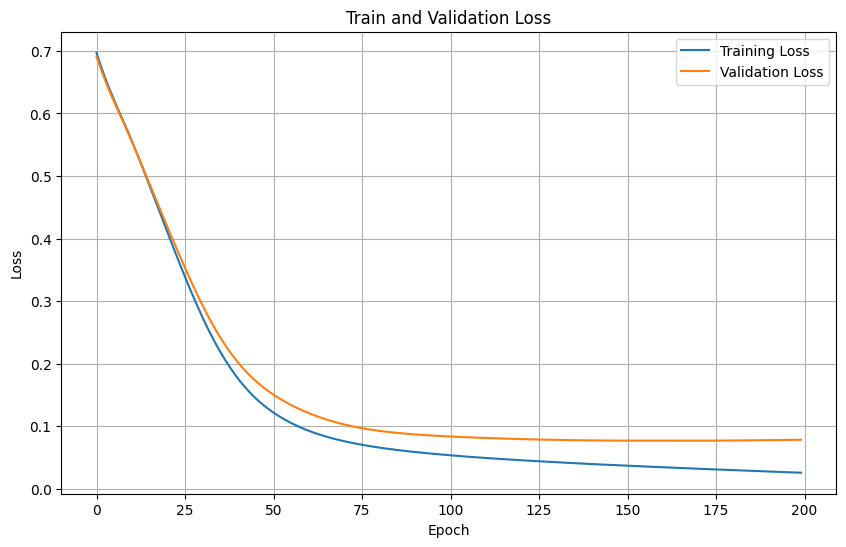

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

fcnn.eval()

with torch.no_grad():
    y_pred_logits = fcnn(x_test)
    y_pred_prob = torch.sigmoid(y_pred_logits)
    y_pred_class = (y_pred_prob > 0.5).float()

y_test_np = y_test.numpy()
y_pred_class_np = y_pred_class.detach().numpy()

acc = accuracy_score(y_test_np, y_pred_class_np)
pre = precision_score(y_test_np, y_pred_class_np)
rec = recall_score(y_test_np, y_pred_class_np)
f1 = f1_score(y_test_np, y_pred_class_np)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {pre:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(confusion_matrix(y_test_np, y_pred_class_np))

Accuracy:  0.9735
Precision: 0.9863
Recall:    0.9730
F1-Score:  0.9796
[[38  1]
 [ 2 72]]
